# Voting methods

This notebook compares a number of common voting methods. We are going to be using 2D images to visualize how different voting schemes function in a world where voter and candidate ideologies are represented on a 2D scale; this method is blatantly stolen from [Ka-Ping Yee's fantastic research](http://zesty.ca/voting/sim/).

Each pixel in a generated image image will be colored with the winner of an election with that pixel's coordinates as the centerpoint of the population's political distribution, with voters normally distributed around that point.

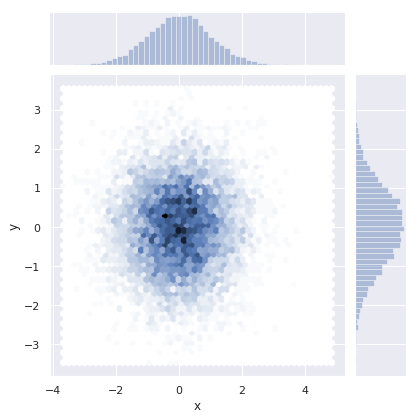

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from randomgen import RandomGenerator, MT19937 # could use Xoroshiro128, but lower quality randomness and not much faster
%matplotlib inline

rnd = RandomGenerator(MT19937())

def generate_population(x, y, n=10000, sigma=1):
    x = rnd.normal(x, sigma, n)
    y = rnd.normal(y, sigma, n)
    return np.hstack((x[:, None], y[:, None]))

voters = generate_population(0, 0)
sns.set(rc={'figure.figsize':(4, 4)})
sns.jointplot(x='x', y='y', data=pd.DataFrame(voters, columns=['x', 'y']), kind='hex')

There are two main categories of voting systems: ordinal and cardinal. In ordinal systems, voters rank the candidates in an order of preference. In cardinal systems, voters assign a score to each candidate to represent the magnitude of preference as well. Voters will prefer candidates that are closest in the space, with the order of preference determined by distance from the voter.

In [2]:
from math import sqrt

def distance(voter, candidate):
    return sqrt((voter['x'] - candidate['x'])**2 + (voter['y'] - candidate['y'])**2)

voter1 = {'x': 0.5, 'y': 1.5}
candidate1 = {'x': 1.0, 'y': 2.0}
candidate2 = {'x': 4.0, 'y': 4.0}

assert distance(voter1, candidate1) < distance(voter1, candidate2)

First, we will implement plurality voting, the simplest form of ordinal voting. It is simple and will be familiar to anybody living in the United States. Voters use a single vote to select their most-preferred candidate, and the candidate with the most votes wins.

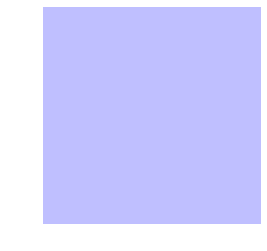

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import BASE_COLORS as colors
import numba

@numba.jit(nopython=True, cache=True)
def simulate_tally(voters, candidates):
    votes = np.zeros(candidates.shape[0])

    for v in range(len(voters)):
        selection = 0
        best_distance = np.inf
        for c in range(len(candidates)):
            this_distance = np.sqrt((candidates[c, 0] - voters[v, 0])**2 + (candidates[c, 1] - voters[v, 1])**2)
            if this_distance < best_distance:
                best_distance = this_distance
                selection = c

        votes[selection] += 1

        return votes

def plurality(voters, candidates):
    inner_candidates = np.array([[c['x'], c['y']] for c in candidates])
    tallied = simulate_tally(voters, inner_candidates)   
    return candidates[tallied.argmax()]['color']
    
def cand(x, y, color):
    return {'x': x, 'y': y, 'color': tuple(255 * n for n in color) + (64,)}

candidates = [cand(0, 0, colors['b']), cand(2, 2, colors['y'])]

img = plurality(generate_population(0, 0), candidates) # an image of 1 election
plt.axis('off')
plt.imshow([[img]])

With our voter population, preference metric, and voting system defined, we can define our simulation and run a test image of size 64x64.

In [14]:
from functools import partial
from pathos.multiprocessing import ProcessingPool
from tqdm import tqdm_notebook as tqdm

def run_system(candidates, system, size=128):
    arr = np.zeros((size, size, 4), dtype=np.uint8)
    
    elections = [(x, y) for x in range(size) for y in range(size)]
    
    results = []
    for x, y in tqdm(elections):
        arr[x][y] = system(generate_population(x, y), candidates)

    return arr
    
# keep in mind that these centers are pixel coordinates
size = 64
candidates = [cand(size / 3, size / 3, colors['b']), cand(size / 2, size / 2, colors['y'])]

# %prun could be handy here
img = run_system(candidates, plurality, size=size)

# make candidate locations more visible
for candidate in candidates:
    img[candidate['x']][candidate['y']][3] = 255

plt.axis('off')
plt.imshow(img)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices